In [1]:
import numpy as np
import pandas as pd
import urllib.request as requests
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import unicodedata
import regex as re
from pyvi import ViTokenizer, ViPosTagger

In [2]:
data = pd.read_csv('reviews.csv')
data

,sentiment,comment
0,4,"Màu sắc:xám , đen Đúng với mô tả:Chưa bóc hàng..."
1,5,Chất liệu:mềm Màu sắc:đen Rất đáng để mua 👍hì...
2,5,Giao hàng nhanh. Sản phẩm đẹp nhưng mà hơi mỏ...
3,3,"vải có vẻ dãn, nhìn hơi to nhưng cũng khá đẹp ..."
4,5,"tất mỏng, mỏng như tờ.. nói chung đi hết mùa đ..."
...,...,...
3307,2,Hương vị:ổn Ib thắc mắc thì k thèm tl
3308,4,Đặt 1 kiểu giao 1 kiểu
3309,3,Khách nhắn tin không thèm rep
3310,4,Shop đóng hàng k bọc kĩ hộp sữa bị méo rách hic


Text(0.5, 1.0, 'Count of reviews by starts')

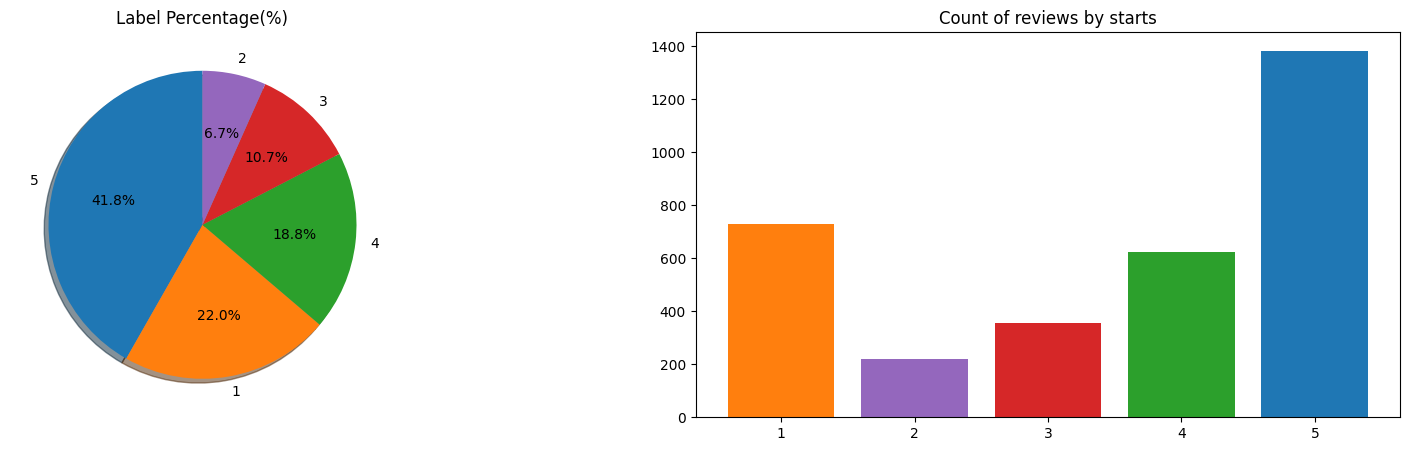

In [3]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

labels = data['sentiment'].value_counts().keys()
sizes = data['sentiment'].value_counts()

axes[0].pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Label Percentage(%)')
axes[1].bar(labels, sizes, color=sns.color_palette())
axes[1].set_title('Count of reviews by starts')

Pre Processing

In [4]:
stop_words = []
with open('vietnamese-stopwords.txt', encoding='utf-8') as f:
    stop_words = [t for t in f.read().split('\n')]

In [5]:

sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1"

# Defining regex for emojis
smile_emoji        = r"[8:=;]['`\-]?[)d]+"
sad_emoji          = r"[8:=;]['`\-]?\(+"
neutral_emoji      = r"[8:=;]['`\-]?[\/|l*]"

def preprocess(input:str):
    input = unicodedata.normalize('NFC', input)
    
    # Lower
    input = input.lower()
    # clean
    input = input.strip().replace('\n', '')
    
    input = re.sub(sequencePattern, seqReplacePattern, input)
    
    # Replace all emojis.
    input = re.sub(r'<3', 'tim', input)
    input = re.sub(smile_emoji, 'vui', input)
    input = re.sub(sad_emoji, 'buồn', input)
    input = re.sub(neutral_emoji, 'bình thường', input)
    
    # Keep word
    input = re.sub('https?://\S+|www\.\S+', ' ', input)
    input = re.sub('[%s]' % re.escape(string.punctuation), ' ', input)
    
    input = ViTokenizer.tokenize(input)

    return ' '.join([word for word in input.split() if word not in stop_words])

data.dropna()
data["processed"] = data["comment"].apply(lambda x: preprocess(x))
data.head(10)

def scale(x:int):
    if x > 3:
        return x/5
    return 0
data["sentiment"] = data["sentiment"].apply(lambda x: scale(x))
data

,sentiment,comment,processed
0,0.8,"Màu sắc:xám , đen Đúng với mô tả:Chưa bóc hàng...",màu_sắc xám đen đúng mô_tả bóc hàng đúng mí mô...
1,1.0,Chất liệu:mềm Màu sắc:đen Rất đáng để mua 👍hì...,chất_liệu mềm màu_sắc đen mua 👍 hình_ảnh video...
2,1.0,Giao hàng nhanh. Sản phẩm đẹp nhưng mà hơi mỏ...,giao hàng sản_phẩm đẹp hơi mỏng chút nói_chung...
3,0.0,"vải có vẻ dãn, nhìn hơi to nhưng cũng khá đẹp ...",vải vẻ dãn hơi to khá đẹp 🤥 rẻ như_vậy
4,1.0,"tất mỏng, mỏng như tờ.. nói chung đi hết mùa đ...",tất mỏng mỏng tờ nói_chung đi mùa đông roãng đ...
...,...,...,...
3307,0.0,Hương vị:ổn Ib thắc mắc thì k thèm tl,hương_vị ổn ib thắc_mắc k thèm tl
3308,0.8,Đặt 1 kiểu giao 1 kiểu,1 kiểu giao 1 kiểu
3309,0.0,Khách nhắn tin không thèm rep,nhắn_tin không thèm rep
3310,0.8,Shop đóng hàng k bọc kĩ hộp sữa bị méo rách hic,shop đóng hàng k bọc kĩ hộp sữa méo rách hic


Text(0.5, 1.0, 'Mean of reviews after processed: 11')

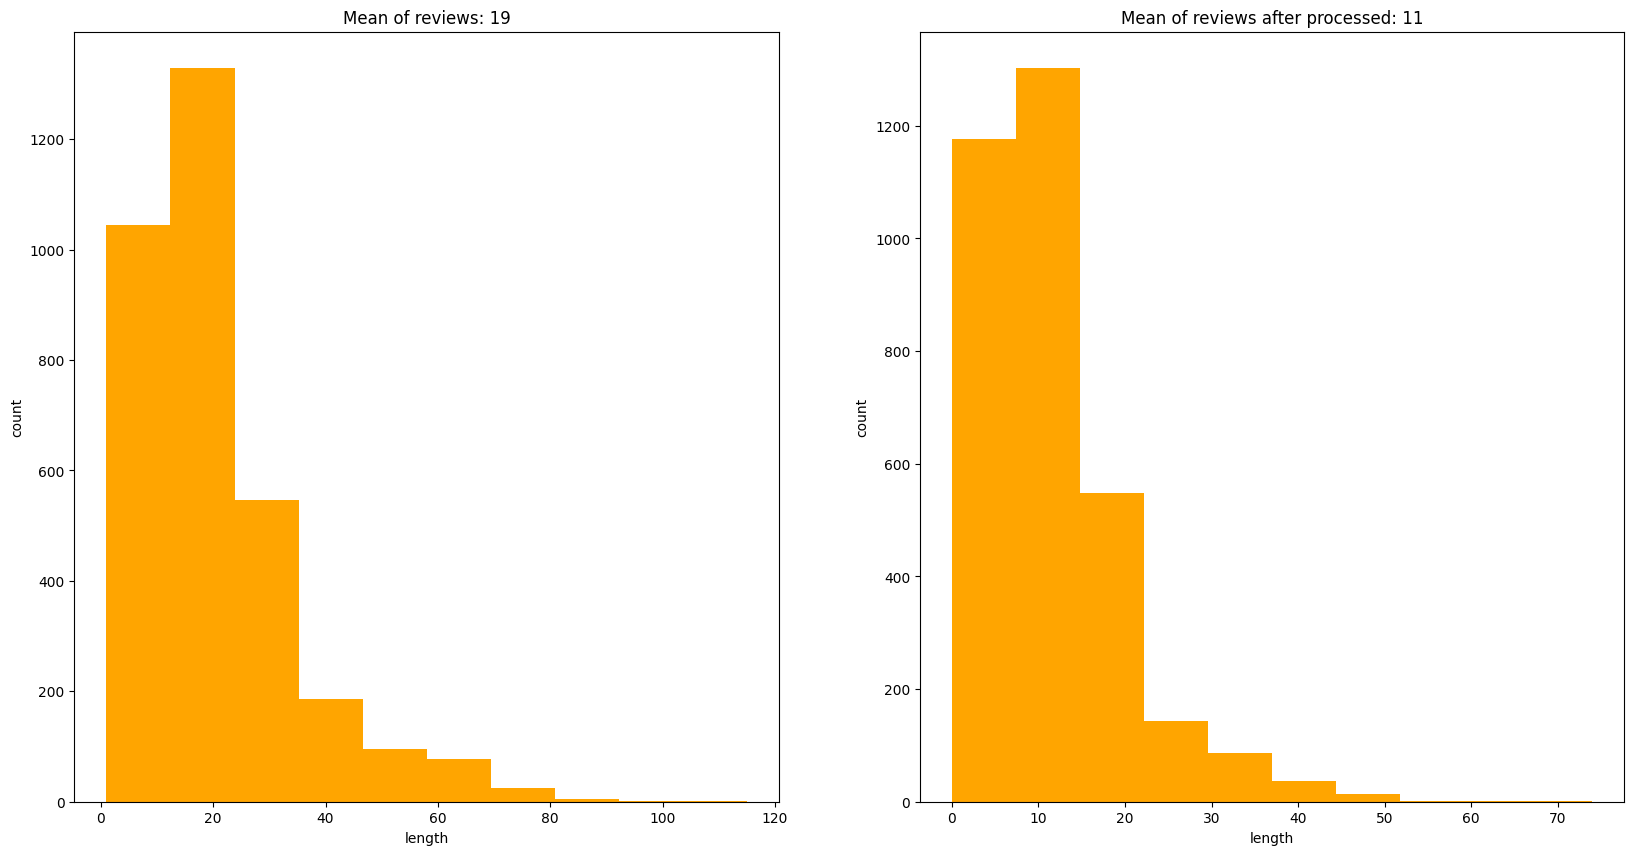

In [6]:
# Histogram
comment_len = [len(x.split()) for x in data['comment']]
processed_len = [len(x.split()) for x in data['processed']]

fig, axes = plt.subplots(1,2, figsize=(20, 10))
axes[0].hist(x=comment_len, color="orange")
axes[0].set_xlabel('length')
axes[0].set_ylabel('count')
axes[0].set_title(f'Mean of reviews: {np.mean(comment_len, dtype=np.int32)}')

axes[1].hist(x=processed_len, color="orange")
axes[1].set_xlabel('length')
axes[1].set_ylabel('count')
axes[1].set_title(f'Mean of reviews after processed: {np.mean(processed_len, dtype=np.int32)}')

In [7]:
# word cloud
def get_word_cloud(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    word_cloud = WordCloud(background_color=color, width=2500, height=2000).generate(cleaned_word)
    return word_cloud
comment_word_cloud = get_word_cloud(data['comment'])
processed_word_cloud = get_word_cloud(data['processed'])

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Bidirectional, SimpleRNN
from sklearn.model_selection import train_test_split


In [9]:
vocab_size = 5000
embedding_dim = 64
max_length = 30

sequences = data.processed
labels = data.sentiment

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(sequences)

In [10]:
X_train, X_test, train_labels, test_labels = train_test_split(sequences, labels, test_size = 0.2, random_state = 42)

In [11]:
train_sequences = tokenizer.texts_to_sequences(X_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')

test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')

Model 1: RNN

In [12]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(SimpleRNN(32))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model1.fit(padded_train_sequences, train_labels, batch_size=1024, epochs=10, validation_split=0.1,
                      verbose=1, validation_data=(padded_test_sequences, test_labels))

Epoch 1/10
3/3 [==============================] - 1s 142ms/step - loss: 0.6836 - accuracy: 0.4436 - val_loss: 0.6794 - val_accuracy: 0.4404
Epoch 2/10
3/3 [==============================] - 0s 40ms/step - loss: 0.6607 - accuracy: 0.5059 - val_loss: 0.6675 - val_accuracy: 0.4977
Epoch 3/10
3/3 [==============================] - 0s 38ms/step - loss: 0.6391 - accuracy: 0.5466 - val_loss: 0.6532 - val_accuracy: 0.5053
Epoch 4/10
3/3 [==============================] - 0s 37ms/step - loss: 0.6118 - accuracy: 0.5617 - val_loss: 0.6313 - val_accuracy: 0.5370
Epoch 5/10
3/3 [==============================] - 0s 36ms/step - loss: 0.5673 - accuracy: 0.6402 - val_loss: 0.6037 - val_accuracy: 0.5792
Epoch 6/10
3/3 [==============================] - 0s 37ms/step - loss: 0.5179 - accuracy: 0.6799 - val_loss: 0.5782 - val_accuracy: 0.5973
Epoch 7/10
3/3 [==============================] - 0s 35ms/step - loss: 0.4709 - accuracy: 0.7063 - val_loss: 0.5489 - val_accuracy: 0.6214
Epoch 8/10
3/3 [==========

In [13]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model2.add(Bidirectional(LSTM(32)))
# model2.add(Bidirectional(LSTM(units=128, return_sequences=True)))
# model2.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(padded_train_sequences, train_labels, batch_size=1024, epochs=20, validation_split=0.1, 
                      verbose=1, validation_data=(padded_test_sequences, test_labels))

Epoch 1/20
3/3 [==============================] - 4s 410ms/step - loss: 0.6929 - accuracy: 0.3934 - val_loss: 0.6909 - val_accuracy: 0.3967
Epoch 2/20
3/3 [==============================] - 0s 94ms/step - loss: 0.6887 - accuracy: 0.4228 - val_loss: 0.6876 - val_accuracy: 0.3967
Epoch 3/20
3/3 [==============================] - 0s 88ms/step - loss: 0.6840 - accuracy: 0.4228 - val_loss: 0.6841 - val_accuracy: 0.3967
Epoch 4/20
3/3 [==============================] - 0s 86ms/step - loss: 0.6786 - accuracy: 0.4228 - val_loss: 0.6798 - val_accuracy: 0.3967
Epoch 5/20
3/3 [==============================] - 0s 82ms/step - loss: 0.6720 - accuracy: 0.4228 - val_loss: 0.6744 - val_accuracy: 0.3967
Epoch 6/20
3/3 [==============================] - 0s 83ms/step - loss: 0.6637 - accuracy: 0.4228 - val_loss: 0.6665 - val_accuracy: 0.3967
Epoch 7/20
3/3 [==============================] - 0s 84ms/step - loss: 0.6519 - accuracy: 0.4572 - val_loss: 0.6544 - val_accuracy: 0.4842
Epoch 8/20
3/3 [==========

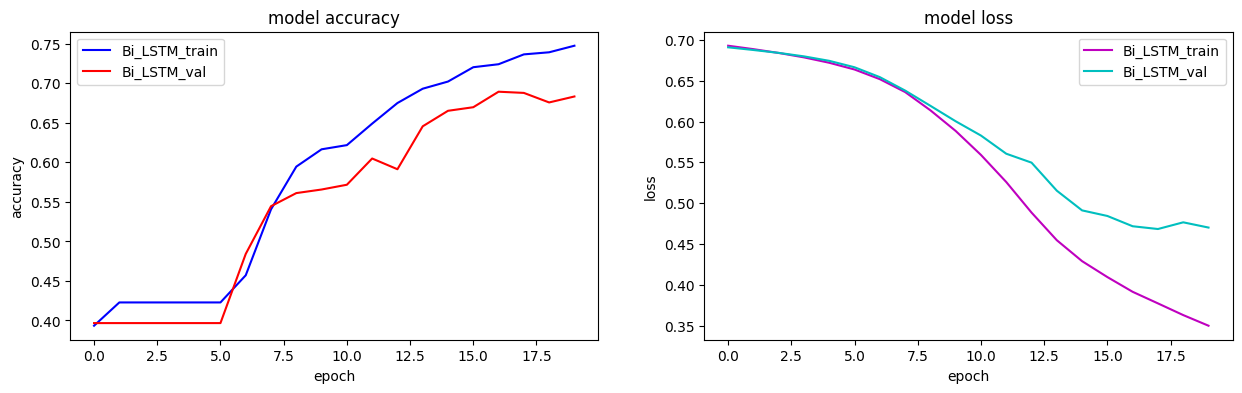

In [14]:
s, (at, al) = plt.subplots(1, 2, figsize=(15,4))
at.plot(history2.history['accuracy'], c= 'b', label='Bi_LSTM_train')
at.plot(history2.history['val_accuracy'], c='r', label='Bi_LSTM_val')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend()

al.plot(history2.history['loss'], c='m', label='Bi_LSTM_train')
al.plot(history2.history['val_loss'], c='c', label='Bi_LSTM_val')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend()

In [15]:
def my_predict(input:list):
    input = [preprocess(i) for i in input]
    text_tokenizer = tokenizer.texts_to_sequences(pd.Series(input))
    padded_test = pad_sequences(text_tokenizer, maxlen=max_length, truncating='post', padding='post')
    y_predict = model2.predict(padded_test)
    for t, pred in zip(input, y_predict):
        print(f'{t} : {sentiment(pred)} ({pred.round(decimals=3)})')

def sentiment(x:int):
    if x > 0.6:
        return 'positive'
    if x > 0.4:
        return 'neutral'
    return 'negative'

In [16]:
my_predict(['Đã nhận được sản phẩm, ổn trong tầm giá, tuốt cũng ok.. Nếu có thêm lò xo hoặc gì đó đẩy phần chuôi tự động mở thì sẽ tiện hơn nữa..'])

1/1 [==============================] - 1s 595ms/step
sản_phẩm ổn tầm giá tuốt ok lò_xo đẩy chuôi tự_động tiện hơn_nữa : positive ([0.945])
